In [1]:
%matplotlib inline
import gym
import time

import torch.nn as nn
from tqdm import tnrange, tqdm_notebook

from rainbow import Rainbow

from torch.utils.tensorboard import SummaryWriter
from utils import plot_var_history, get_model_name

In [2]:
def run_experient(env, num_runs, num_episodes, agent_args,
                  tb_path=None, model_name='model_joe',
                  render_env=False, plot_value_func=False,
                  plot_state_visit=False):
    reward_history = []
    agents_hist = []
    state_dim = env.observation_space.shape[0]
    assert isinstance(env.action_space, gym.spaces.Discrete), \
        "Action space is not discrete"
    act_dim = env.action_space.n
    for i, agent_kwargs in enumerate(agent_args):
        reward_history.append([])
        # Start the runs for each setting
        for run in tqdm_notebook(range(1, num_runs+1), desc='Config %d'%(i+1), leave=False):
            reward_history[i].append([])
            env.seed(run)
            agent_kwargs["seed"] = run
            agent = Rainbow(state_dim, act_dim, **agent_kwargs)
            if run == 1 and tb_path:
                writer = SummaryWriter(tb_path + '/' + agent.__str__() +
                                       '/' + model_name)
            # Start the episodes
            for episode in tqdm_notebook(range(1, num_episodes+1), desc='Episodes', leave=False):
                observation = env.reset()
                done = False
                time_step = 0
                action = agent.start(observation)
                # Start interaction with environment
                while not done:
                    if render_env:
                        env.render()
                        time.sleep(0.001)
                    # Take a step in the environment
                    observation, reward, done, info = env.step(action)
                    time_step += 1
                    if not done:
                        # Get next action from agent
                        action = agent.take_step(reward, observation)
                    else:
                        episode_reward = agent.end(reward)
                # post episode processing
                reward_history[i][run-1].append(episode_reward)
                if run == 1 and tb_path:
                    writer.add_scalar('Episode Reward',
                                      episode_reward, episode)
                    if episode % 25 == 0:
                        data = agent.get_train_data()
                        writer.add_scalar('Loss', data.get('loss'), episode)
            if run == 1:
                agents_hist.append(agent)
                if tb_path:
                    writer.close()
    env.close()
    return reward_history, agents_hist

In [3]:
# Setup Cart Pole environment
Environment = 'CartPole-v1'
cart_pole_env = gym.make(Environment)

In [4]:
agent_args = [{'hid_lyrs': [64, 64], 'target_update_freq': 10, 'activation': nn.ReLU,
               'mini_batch': 128, 'discount': 0.999, 'replay_mem': 10000,
               'max_lr': None, 'lr': 0.001, 'anneal_period': 500,
               'eps_ini': 0.9, 'eps_fin': 0.05, 'explo_period': 1000},
               {'hid_lyrs': [64, 64], 'target_update_freq': 10, 'activation': nn.ReLU,
               'mini_batch': 128, 'discount': 0.999, 'replay_mem': 10000,
               'max_lr': None, 'lr': 0.001, 'anneal_period': 500,
               'eps_ini': 0.9, 'eps_fin': 0.05, 'explo_period': 1000,
               'no_duel': True},
               {'hid_lyrs': [64, 64], 'target_update_freq': 10, 'activation': nn.ReLU,
               'mini_batch': 128, 'discount': 0.999, 'replay_mem': 10000,
               'max_lr': None, 'lr': 0.001, 'anneal_period': 500,
               'eps_ini': 0.9, 'eps_fin': 0.05, 'explo_period': 1000,
               'no_double': True}]

reward_hist, agent_hist = run_experient(env=cart_pole_env,
                                        num_runs=3, num_episodes=250,
                                        agent_args=agent_args,
                                        tb_path='../runs/', render_env=False)

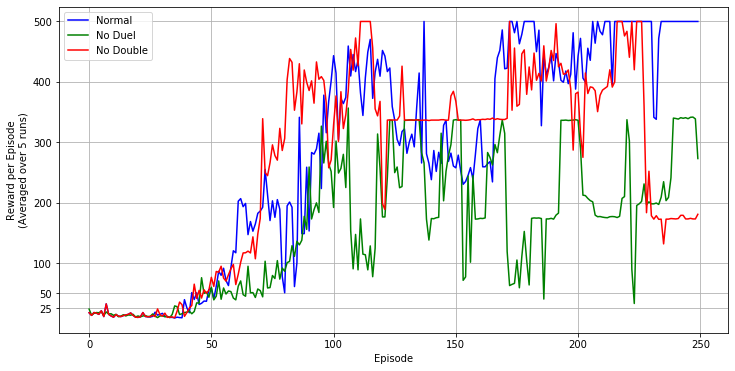

In [6]:
# Plot Results
plot_args = {'x_label': 'Episode',
             'y_label': 'Reward per Episode\n(Averaged over 5 runs)',
             'log_scale': False,
             'y_ticks': [25, 50, 100, 200, 300, 400, 500]}

labels = ["Normal", "No Duel", "No Double"]

plot_var_history(reward_hist, labels, **plot_args)